# Data insights

## Load data

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("CallDataAnalysis") \
    .getOrCreate()

In [2]:
file_path = "output/processed_emergency_data.csv"

df = spark.read.csv(
    file_path,
    header=True,
    inferSchema=True
)

df.printSchema()

root
 |-- call_id: string (nullable = true)
 |-- ring_timestamp_unix: long (nullable = true)
 |-- pick_up_timestamp_unix: long (nullable = true)
 |-- call_end_timestamp: timestamp (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- call_taker_station_id: string (nullable = true)
 |-- agent_id: string (nullable = true)
 |-- ring_timestamp: timestamp (nullable = true)
 |-- pickup_timestamp: timestamp (nullable = true)
 |-- call_duration_seconds: integer (nullable = true)
 |-- total_number_of_agents: integer (nullable = true)



## Busy hours

Traffic intensity, measured in Erlangs, quantifies the load offered to a call center relative to its capacity. It is calculated as:

**Erlangs = (Call Arrival Rate × Average Handling Time) / Number of Available Agents**

Interpretation:

1 Erlang per agent → agent is busy 100% of the time

<1 Erlang per agent → agents have idle time

\>1 Erlang per agent → system is overloaded, queues may form

In [3]:
from pyspark.sql import functions as F

df = df.withColumn("pickup_ts", F.to_timestamp("pickup_timestamp")) \
       .withColumn("pickup_date", F.to_date("pickup_ts")) \
       .withColumn("pickup_hour", F.hour("pickup_ts"))

In [4]:
hourly = (
    df.groupBy("pickup_date", "pickup_hour")
      .agg(
          F.count("call_id").alias("call_count"),
          F.avg("call_duration_seconds").alias("avg_handle_time"),
          F.avg("total_number_of_agents").alias("avg_agents")
      )
)

hourly = hourly.withColumn(
    "erlangs",
    (F.col("call_count") / 3600) * F.col("avg_handle_time") / F.col("avg_agents")
)

In [5]:
daily = (
    df.groupBy("pickup_date")
      .agg(
          F.count("call_id").alias("call_count"),
          F.avg("call_duration_seconds").alias("avg_handle_time"),
          F.avg("total_number_of_agents").alias("avg_agents")
      )
)

daily = daily.withColumn(
    "erlangs",
    (F.col("call_count") / 86400) * F.col("avg_handle_time") / F.col("avg_agents")
)

In [6]:
hourly_ordered = hourly.orderBy("pickup_date", "pickup_hour")
hourly_ordered.show(50, truncate=False)

daily_ordered = daily.orderBy("pickup_date")
daily_ordered.show(20, truncate=False)

+-----------+-----------+----------+-----------------+------------------+-------------------+
|pickup_date|pickup_hour|call_count|avg_handle_time  |avg_agents        |erlangs            |
+-----------+-----------+----------+-----------------+------------------+-------------------+
|2024-06-15 |0          |30        |574.3333333333334|15.0              |0.3190740740740741 |
|2024-06-15 |1          |27        |655.8518518518518|15.0              |0.3279259259259259 |
|2024-06-15 |2          |28        |693.9642857142857|15.0              |0.3598333333333333 |
|2024-06-15 |3          |29        |624.448275862069 |15.0              |0.3353518518518518 |
|2024-06-15 |4          |26        |637.0384615384615|15.0              |0.30672222222222223|
|2024-06-15 |5          |30        |657.2333333333333|14.0              |0.3912103174603175 |
|2024-06-15 |6          |26        |640.6538461538462|15.0              |0.308462962962963  |
|2024-06-15 |7          |24        |560.7916666666666|15.0  

In [7]:
import pandas as pd

# Hourly
pdf_hourly = hourly_ordered.toPandas()
pdf_hourly["datetime"] = pd.to_datetime(pdf_hourly["pickup_date"].astype(str) + " " + pdf_hourly["pickup_hour"].astype(str) + ":00:00")

# Daily
pdf_daily = daily_ordered.toPandas()
pdf_daily["date"] = pd.to_datetime(pdf_daily["pickup_date"])

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

sns.set_style("whitegrid")  # cleaner background
plt.rcParams.update({'font.size': 12})  # global font size

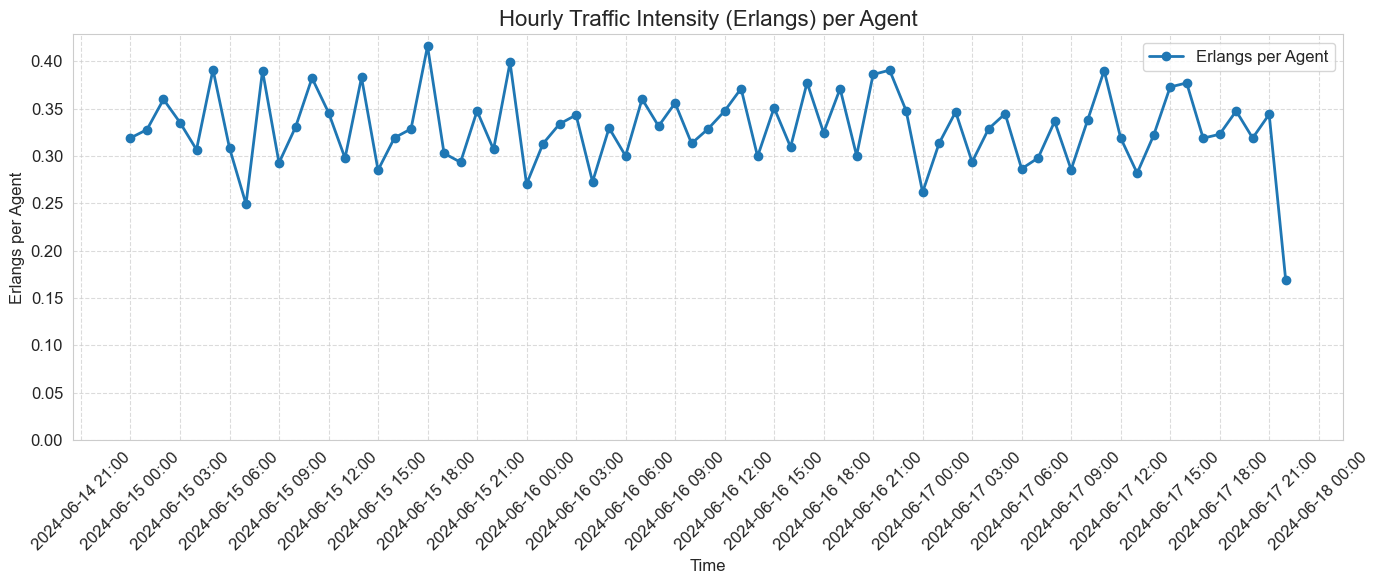

In [9]:
plt.figure(figsize=(14,6))

plt.plot(pdf_hourly["datetime"], pdf_hourly["erlangs"],
         marker="o", color="#1f77b4", linewidth=2, markersize=6, label="Erlangs per Agent")

# X-axis formatting: show every 3 hours to reduce clutter
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=3))

# Y-axis starts at 0
plt.ylim(bottom=0)

plt.title("Hourly Traffic Intensity (Erlangs) per Agent", fontsize=16)
plt.xlabel("Time")
plt.ylabel("Erlangs per Agent")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

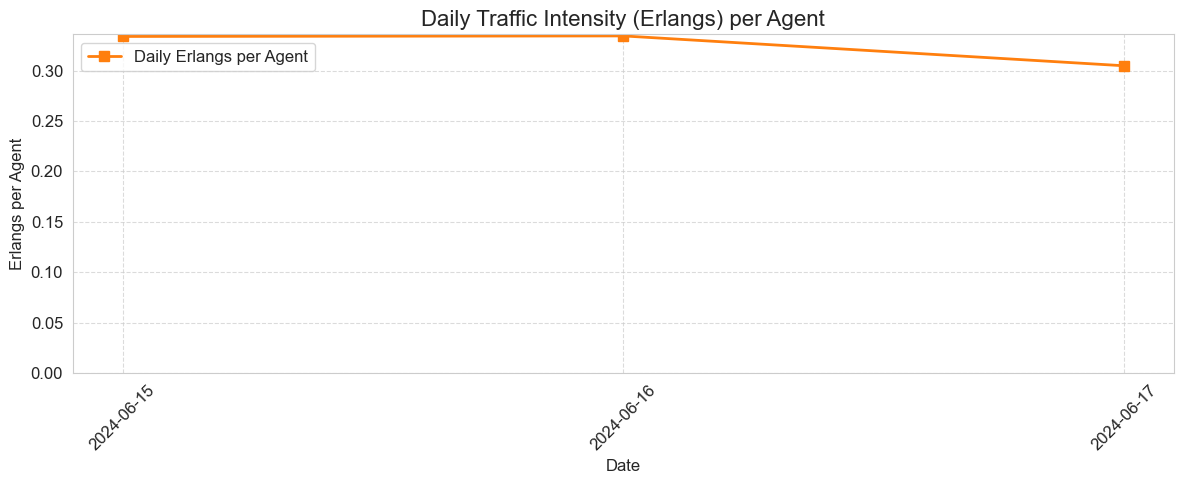

In [10]:
plt.figure(figsize=(12,5))

plt.plot(pdf_daily["date"], pdf_daily["erlangs"],
         marker="s", color="#ff7f0e", linewidth=2, markersize=7, label="Daily Erlangs per Agent")

# X-axis formatting: one tick per day
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))

# Y-axis starts at 0
plt.ylim(bottom=0)

plt.title("Daily Traffic Intensity (Erlangs) per Agent", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Erlangs per Agent")
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

## Agent performance

### Normalized relative productivity index

Productivity Index (Normalized)

Combines efficiency and service quality into a relative ranking metric.

Raw formula (before normalization):

**Productivity Index = ( Total Calls / Total Handle Time (s) ) × ( 1 / (1 + Average Wait Time (s)) )**

Normalized between 0 and 1 across all agents:

1 → most productive agent

0 → least productive agent

In [11]:
# Convert to timestamp type if not already
df = df.withColumn("ring_ts", F.to_timestamp("ring_timestamp")) \
       .withColumn("pickup_ts", F.to_timestamp("pickup_timestamp"))

# Compute wait time in seconds
df = df.withColumn("wait_time_seconds", F.col("pickup_ts").cast("long") - F.col("ring_ts").cast("long"))

In [12]:
agent_stats = (
    df.groupBy("agent_id")
      .agg(
          F.count("call_id").alias("total_calls"),
          F.sum("call_duration_seconds").alias("total_handle_time"),
          F.avg("call_duration_seconds").alias("avg_handle_time"),
          F.avg("wait_time_seconds").alias("avg_wait_time")
      )
)

agent_stats = agent_stats.dropna(subset=["agent_id"])

agent_stats = agent_stats.withColumn(
    "productivity_index",
    (F.col("total_calls") / F.col("total_handle_time")) / (1 + F.col("avg_wait_time"))
)

agent_stats.show()

+--------+-----------+-----------------+-----------------+------------------+--------------------+
|agent_id|total_calls|total_handle_time|  avg_handle_time|     avg_wait_time|  productivity_index|
+--------+-----------+-----------------+-----------------+------------------+--------------------+
|AGENT_14|         97|            61974|638.9072164948453|1.0206185567010309|7.746006719078376E-4|
|AGENT_15|        108|            67385|623.9351851851852| 1.212962962962963|7.242464536667616E-4|
|AGENT_01|         97|            60828|627.0927835051547|1.0206185567010309|7.891941546790348E-4|
|AGENT_05|         96|            59696|621.8333333333334|1.0833333333333333|7.719110158134549E-4|
|AGENT_18|         99|            62792|634.2626262626262|0.9292929292929293|8.172081813870311E-4|
|AGENT_02|         96|            62803|654.1979166666666|           1.03125|7.525363193086073E-4|
|AGENT_10|         99|            63777|644.2121212121212|0.8787878787878788|8.262155383147023E-4|
|AGENT_13|

In [13]:
stats = agent_stats.agg(
    F.min("productivity_index").alias("min_index"),
    F.max("productivity_index").alias("max_index")
).collect()[0]

min_index = stats["min_index"]
max_index = stats["max_index"]

agent_stats = agent_stats.withColumn(
    "productivity_index_norm",
    (F.col("productivity_index") - F.lit(min_index)) / (F.lit(max_index) - F.lit(min_index))
)

agent_stats.show()

+--------+-----------+-----------------+-----------------+------------------+--------------------+-----------------------+
|agent_id|total_calls|total_handle_time|  avg_handle_time|     avg_wait_time|  productivity_index|productivity_index_norm|
+--------+-----------+-----------------+-----------------+------------------+--------------------+-----------------------+
|AGENT_14|         97|            61974|638.9072164948453|1.0206185567010309|7.746006719078376E-4|     0.3549990890622897|
|AGENT_15|        108|            67385|623.9351851851852| 1.212962962962963|7.242464536667616E-4|                    0.0|
|AGENT_01|         97|            60828|627.0927835051547|1.0206185567010309|7.891941546790348E-4|    0.45788367889383497|
|AGENT_05|         96|            59696|621.8333333333334|1.0833333333333333|7.719110158134549E-4|     0.3360369147549585|
|AGENT_18|         99|            62792|634.2626262626262|0.9292929292929293|8.172081813870311E-4|      0.655383596670194|
|AGENT_02|      

In [14]:
from pyspark.sql.window import Window

window = Window.orderBy(F.desc("productivity_index_norm"))
agent_stats = agent_stats.withColumn("rank", F.rank().over(window))

agent_stats.select("agent_id", "total_calls", "avg_handle_time", "avg_wait_time",
                   "productivity_index_norm", "rank").show(10, truncate=False)

+--------+-----------+-----------------+------------------+-----------------------+----+
|agent_id|total_calls|avg_handle_time  |avg_wait_time     |productivity_index_norm|rank|
+--------+-----------+-----------------+------------------+-----------------------+----+
|AGENT_03|99         |638.5858585858585|0.8080808080808081|1.0                    |1   |
|AGENT_13|100        |620.59           |0.94              |0.7498175800825913     |2   |
|AGENT_10|99         |644.2121212121212|0.8787878787878788|0.7188857940208376     |3   |
|AGENT_18|99         |634.2626262626262|0.9292929292929293|0.655383596670194      |4   |
|AGENT_09|99         |623.7777777777778|0.9797979797979798|0.6027803729048384     |5   |
|AGENT_16|88         |633.3522727272727|0.9886363636363636|0.49149166139446443    |6   |
|AGENT_20|92         |616.5326086956521|1.0434782608695652|0.4898761304331225     |7   |
|AGENT_11|93         |645.8924731182796|0.956989247311828 |0.47157619795919886    |8   |
|AGENT_01|97         

### Absolute productivity score

Measures calls handled per effective hour, adjusted for wait time, giving real-world interpretability.

Formula:

**Absolute Productivity = ( Total Calls / Total Handle Time (hours) ) x ( 1 / ( 1 + Average Wait Time (hours) )**

Differences are meaningful: e.g., 20 vs 10 → agent A handles twice as many calls per effective hour as agent B.

In [15]:
# Convert handle time and wait time to hours
agent_stats = agent_stats.withColumn("total_handle_time_hr", F.col("total_handle_time") / 3600)
agent_stats = agent_stats.withColumn("avg_wait_time_hr", F.col("avg_wait_time") / 3600)

agent_stats = agent_stats.dropna(subset=["agent_id"])

# Compute absolute productivity score
agent_stats = agent_stats.withColumn(
    "absolute_productivity",
    (F.col("total_calls") / F.col("total_handle_time_hr")) / (1 + F.col("avg_wait_time_hr"))
)

In [16]:
window = Window.orderBy(F.desc("absolute_productivity"))
agent_stats = agent_stats.withColumn("rank", F.rank().over(window))

agent_stats.select(
    "agent_id", "total_calls", "total_handle_time_hr", "avg_wait_time_hr",
    "absolute_productivity", "rank"
).show(50, truncate=False)

+--------+-----------+--------------------+---------------------+---------------------+----+
|agent_id|total_calls|total_handle_time_hr|avg_wait_time_hr     |absolute_productivity|rank|
+--------+-----------+--------------------+---------------------+---------------------+----+
|AGENT_20|92         |15.755833333333333  |2.898550724637681E-4 |5.837415204563103    |1   |
|AGENT_17|104        |17.897222222222222  |3.125E-4             |5.809142271474124    |2   |
|AGENT_13|100        |17.238611111111112  |2.611111111111111E-4 |5.799417079521702    |3   |
|AGENT_05|96         |16.58222222222222   |3.009259259259259E-4 |5.787590982425645    |4   |
|AGENT_06|106        |18.34861111111111   |2.882599580712788E-4 |5.775339212769021    |5   |
|AGENT_09|99         |17.15388888888889   |2.7216610549943884E-4|5.769715749472568    |6   |
|AGENT_15|108        |18.718055555555555  |3.369341563786008E-4 |5.767886682844963    |7   |
|AGENT_01|97         |16.89666666666667   |2.8350515463917525E-4|5.739

In [17]:
pdf_agents = agent_stats.select(
    "agent_id", "absolute_productivity", "total_calls", "total_handle_time_hr", "avg_wait_time_hr"
).toPandas()

# Sort by absolute productivity descending
pdf_agents = pdf_agents.sort_values(by="absolute_productivity", ascending=True)

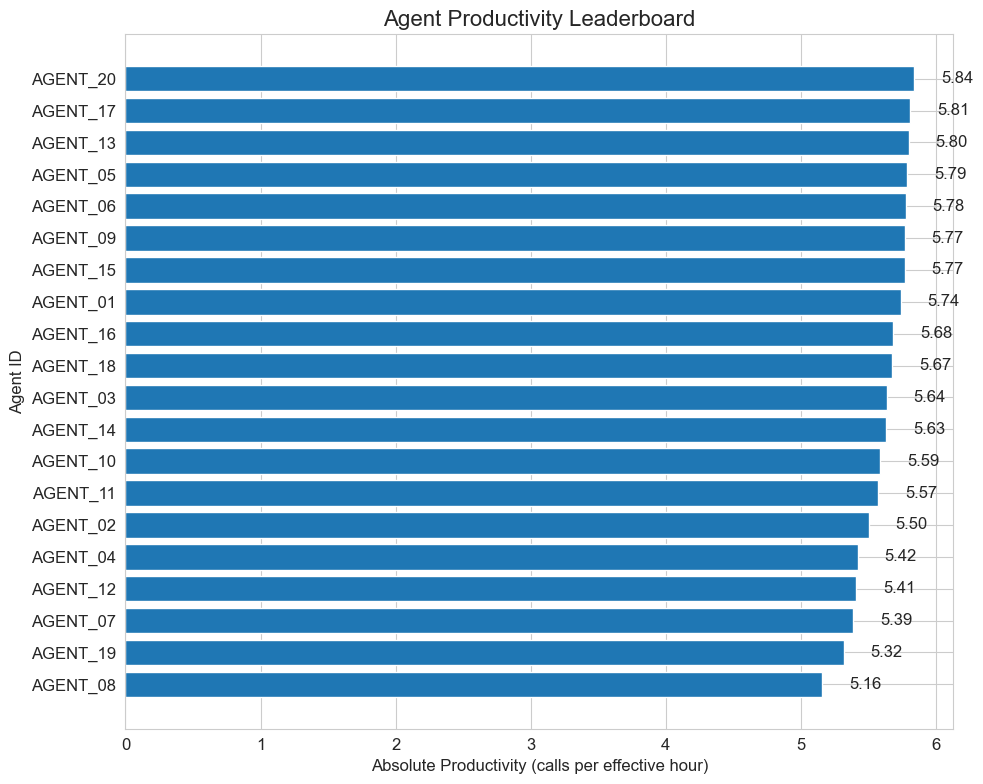

In [18]:
plt.figure(figsize=(10, 8))

# Horizontal bar plot
plt.barh(
    pdf_agents["agent_id"],
    pdf_agents["absolute_productivity"],
    color="#1f77b4"
)

# Add labels and title
plt.xlabel("Absolute Productivity (calls per effective hour)")
plt.ylabel("Agent ID")
plt.title("Agent Productivity Leaderboard", fontsize=16)

# Optional: annotate bars with actual values
for index, value in enumerate(pdf_agents["absolute_productivity"]):
    plt.text(value + 0.2, index, f"{value:.2f}", va='center')

plt.tight_layout()
plt.show()